In [1]:
%matplotlib inline
# these two lines allow you to control the figure size
# %pylab inline
# pylab.rcParams['figure.figsize'] = (2.0, 2.0)
import numpy as np
import pandas
from IPython.display import Image as display
import matplotlib.pyplot as plt
import random
from tqdm import tqdm
import scipy.misc
import scipy.io
from scipy.stats import multivariate_normal
import seaborn
DOT = np.dot
T = np.transpose


## Reading data

In [6]:
data_mat = scipy.io.loadmat('old_faithful.mat')
data = data_mat['data']

## Center data

In [7]:
data = data - data.mean(axis = 0)

## Setting predefined parameters

In [14]:
# the Gaussian means (as column vectors -- ie, the mean for Gaussian 0 is mus[:,0]
mus = np.asarray( [[-1.17288986, -0.11642103],
                   [-0.16526981,  0.70142713]])

 
# the Gaussian covariance matrices
covs = list()
covs.append( 
    np.asarray([[ 0.74072815,  0.09252716],
                [ 0.09252716,  0.5966275 ]]) )
covs.append( 
    np.asarray([[ 0.39312776, -0.46488887],
                [-0.46488887,  1.64990767]]) )
 
# The Gaussian mixing weights
mws = [ 0.68618439, 0.31381561 ]  # called alpha in the slides


## Expectation

In [15]:
#Compute the responsibilities (Eq. 11.27)
def Expectation():
    cluster_1_w = multivariate_normal.pdf(data, mean=mus[:,0], cov=covs[0])
    cluster_2_w = multivariate_normal.pdf(data, mean=mus[:,1], cov=covs[1])
    
    cluster_1_w = cluster_1_w.reshape((272,1))
    cluster_2_w = cluster_2_w.reshape((272,1))
    
    cluster_1_w *= mws[0]
    cluster_2_w *= mws[1]
    
    sum_to_norm  = (cluster_1_w + cluster_2_w)
    cluster_1_w = cluster_1_w / sum_to_norm
    cluster_2_w = cluster_2_w / sum_to_norm
   
    return cluster_1_w, cluster_2_w

## Maximization

In [16]:

def Maximization(cluster_1_w, cluster_2_w):
    # combine weights into 1 matrix
    cluster_probs = np.zeros((2,data.shape[0]))
    cluster_probs[0] = T(cluster_1_w)
    cluster_probs[1] = T(cluster_2_w)
    cluster_probs = np.transpose(cluster_probs)

    # do the argmax to find out which label is assigned to data point
    
    # (272, 1) composed of 0s and 1s, which cluster it belongs most to
    assigned_labels = cluster_probs.argmax(1)
    assigned_labels = assigned_labels.reshape((272,1))
    
    # Get points for each cluster 
    cluster_1_points = data[np.where(assigned_labels == 0)[0]]
    cluster_2_points = data[np.where(assigned_labels == 1)[0]]
    
    cluster_1_N = np.sum(cluster_1_w)
    cluster_2_N = np.sum(cluster_2_w)
    
    
    # New mws ======================
    
    mw_1 = cluster_1_N / float(data.shape[0])
    mw_2 = cluster_2_N / float(data.shape[0])
    new_mws = [ mw_1, mw_2]
    
    # ==============================
    
    
    # New sigma =====================
    sig_sum_1 = np.zeros((2,2))
    sig_sum_2 = np.zeros((2,2))
    
    # using original mus 
    mu_1 = T(mus[:,0].reshape(2,1))
    mu_2 = T(mus[:,1].reshape(2,1))
    
#     mu_1 = new_mu_1
#     mu_2 = new_mu_2
    
    sig_sum_1 = DOT(T(data - mu_1), (data - mu_1) * cluster_1_w) # DOT ( T(x - mu1), (x - mu1) )
    sig_sum_2 = DOT(T(data - mu_2), (data - mu_2) * cluster_2_w) # DOT ( T(x - mu2), (x - mu12) )

    new_sig_1 = sig_sum_1 / cluster_1_N # DOT ( T(x - mu1), (x - mu1) ) /  N_cluster 1
    new_sig_2 = sig_sum_2 / cluster_2_N # DOT ( T(x - mu2), (x - mu12) ) / N_cluster 2
    
    new_covs = list()
    new_covs.append(new_sig_1)
    new_covs.append(new_sig_2)
    
    # ================================
    
    
    # New mus =======================
    new_mu_1 = DOT(T(cluster_1_w),data) / cluster_1_N
    new_mu_2 = DOT(T(cluster_2_w),data) / cluster_2_N
    
    new_mus = np.zeros((2,2))
    new_mus[0] = new_mu_1
    new_mus[1] = new_mu_2
    
    new_mus = T(new_mus)
    
    # ================================
    
    
    
    return new_mws, new_mus, new_covs, cluster_1_points, cluster_2_points

# a, b = Expectation()
# Maximization(a,b)
# print "Happy"

In [17]:
def cov_to_pts( cov ):
    circ = np.linspace( 0, 2*np.pi, 100 )
    sf = np.asarray( [ np.cos( circ ), np.sin( circ ) ] )
    [u,s,v] = np.linalg.svd( cov )
    pmat = u*2.447*np.sqrt(s) # 95% confidence
    return np.dot(  pmat, sf )

        
def plot_it(ax, c_1_w, c_2_w, row, col, title):
    #fig = plt.figure()
    
    #ax1 = fig.add_subplot(111)
    ax[row,col].scatter(data[:,0], data[:,1], c=c_1_w, marker="s")
    ax[row,col].scatter(mus[0][0], mus[1][0], c="black", marker="o", s=100)
    ax[row,col].scatter(mus[0][1], mus[1][1], c="white", marker="o", s=100)
    sigma_1 =  cov_to_pts(covs[0])
    sigma_2 =  cov_to_pts(covs[1])
    ax[row,col].plot(sigma_1[0]+mus[0][0], sigma_1[1]+mus[1][0])
    ax[row,col].plot(sigma_2[0]+mus[0][1], sigma_2[1]+mus[1][1])
    ax[row,col].title.set_text(title)
    

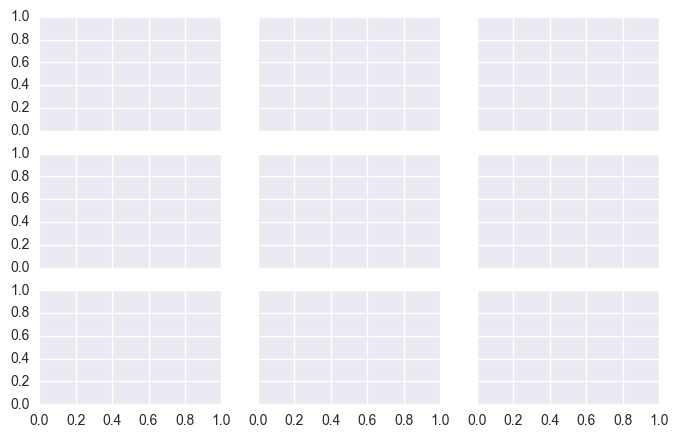

In [18]:
x = -1
l = -1
plt.rcParams['figure.figsize'] = 8, 5
fig, ax = plt.subplots(3,3, sharex = True, sharey = True)
plt.subplots_adjust( wspace = .2, hspace = .2)
for i in xrange(34):
    c_1_w, c_2_w = Expectation()
    mws, mus, covs, cluster_1_points, cluster_2_points = Maximization(c_1_w, c_2_w) 
    break
    if i % 4 == 0:
        l+=1
        y = l % 3
        if y == 0:
            x+=1
        plot_it(ax, c_1_w, c_2_w, x, y, "iteration:"+str(i))
        
        

fig.show()